In [0]:
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 1.x
import tensorflow as tf
import h5py
from tensorflow.python.framework import ops
import pandas as pd
from sklearn.preprocessing import*
%matplotlib inline

In [33]:
!pip show tensorflow

Name: tensorflow
Version: 1.15.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-1.15.2/python3.6
Requires: tensorboard, wrapt, gast, numpy, grpcio, termcolor, astor, six, opt-einsum, google-pasta, tensorflow-estimator, absl-py, wheel, keras-preprocessing, keras-applications, protobuf
Required-by: stable-baselines, magenta, fancyimpute


In [0]:
def createplaceholder(n_x,n_y):
    
    X = tf.placeholder(dtype=tf.float32,shape=[n_x,None],name = 'X')
    Y = tf.placeholder(dtype=tf.float32,shape=[n_y,None],name = 'Y')
    
    return X,Y

In [0]:
def initialize_parameters(layer_dims):
    
    parameters = {}
    #
    for i in range(len(layer_dims)-2):
        
        parameters["W"+str(i+1)] = tf.get_variable("W"+str(i+1),[layer_dims[i+1],layer_dims[i]],initializer = tf.contrib.layers.xavier_initializer(seed =1))
        parameters["b"+str(i+1)] = tf.get_variable("b"+str(i+1),[layer_dims[i+1],1],initializer = tf.zeros_initializer())

    
    return parameters

In [36]:
tf.reset_default_graph()
print(initialize_parameters([12288,25,12,6,1]))

{'W1': <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>, 'b1': <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>, 'W2': <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>, 'b2': <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>, 'W3': <tf.Variable 'W3:0' shape=(6, 12) dtype=float32_ref>, 'b3': <tf.Variable 'b3:0' shape=(6, 1) dtype=float32_ref>}


In [0]:
##activations = ['relu','relu','relu','sigmoid']##
def forward_propagation(X,layer_dims,parameters):

  outputs  ={}
  inputs = {}
  inputs["A0"] = X

  for i in range(1,len(layer_dims) -1):
    outputs["Z" + str(i)] = tf.add(tf.matmul(parameters["W" + str(i)],inputs["A" + str(i-1)]),parameters["b" + str(i)])
    if(i != len(layer_dims) - 2):
      inputs["A"+str(i)] = tf.nn.relu(outputs["Z" + str(i)])
  return outputs["Z"+str(len(layer_dims) -2 )]

In [38]:
tf.reset_default_graph()
parameters = initialize_parameters([3,4,5,6,1])
X,Y= createplaceholder(3,1)
print(forward_propagation(X,[3,4,5,6,1],parameters))

Tensor("Add_2:0", shape=(6, ?), dtype=float32)


In [0]:
def compute_cost(ZL,Y):

  logits = tf.transpose(ZL)
  labels = tf.transpose(Y)

  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits,labels = labels))

  return cost


In [40]:
tf.reset_default_graph()
parameters = initialize_parameters([3,4,5,6,1])
X,Y = createplaceholder(3,1)
print(compute_cost(forward_propagation(X,[3,4,5,6,1],parameters),Y))

Tensor("Mean:0", shape=(), dtype=float32)


In [0]:
def random_minibatches(X,Y,minibatch_size,seed):
  np.random.seed(seed)
  m = X.shape[1]
  minibatches = []

  permutations = list(np.random.permutation(m))
  shuffled_X = X[:,permutations]
  shuffled_Y = Y[:,permutations].reshape((Y.shape[0],m))

  complete_batch = int(m/minibatch_size)

  for i in range(complete_batch):
    minibatch_X = shuffled_X[:,i*minibatch_size:(i+1)*minibatch_size]
    minibatch_Y = shuffled_Y[:,i*minibatch_size:(i+1)*minibatch_size]
    minibatch = (minibatch_X,minibatch_Y)
    minibatches.append(minibatch)

  if(m%minibatch_size != 0):
    minibatch_X = shuffled_X[:,complete_batch*minibatch_size:m]
    minibatch_Y = shuffled_Y[:,complete_batch*minibatch_size:m]
    minibatch = (minibatch_X,minibatch_Y)
    minibatches.append(minibatch)
  
  return minibatches



In [42]:
X = np.matrix([[1,0,2,6],[1,0,2,6],[1,0,2,6]])
Y = np.array([1,2,3,4]).reshape(1,4)
print(random_minibatches(X,Y,3,2))

[(matrix([[2, 6, 0],
        [2, 6, 0],
        [2, 6, 0]]), array([[3, 4, 2]])), (matrix([[1],
        [1],
        [1]]), array([[1]]))]


In [0]:
def model(X_train , Y_train , X_test , Y_test , layer_dims , optimizer , learning_rate = 0.0001 , epochs = 1500 , minibatch_size = 32 ,print_cost = True):

  ops.reset_default_graph()
  tf.set_random_seed(1)
  seed = 3

  (n_x,m) = X_train.shape
  n_y = Y_train.shape[0]
  costs =[]

  X,Y = createplaceholder(n_x,n_y)

  parameters = initialize_parameters(layer_dims)

  ZL = forward_propagation(X,layer_dims,parameters)

  cost = compute_cost(ZL,Y)
  
  if(optimizer == 'adam'):
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
  elif(optimizer == 'gd'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
  
  init = tf.global_variables_initializer()

  with tf.Session() as sess:

    sess.run(init)

    for epoch in range(epochs):
        
        epoch_cost = 0.
        seed +=1
        num_minibatches = int(m/ minibatch_size)
        minibatches = random_minibatches(X_train , Y_train , minibatch_size,seed)

        for minibatch in minibatches:
          (minibatch_X,minibatch_Y) = minibatch

          _, minibatch_cost = sess.run([optimizer , cost],feed_dict = {X:minibatch_X,Y:minibatch_Y})

          epoch_cost +=   minibatch_cost / minibatch_size

        if print_cost == True and epoch % 100 ==0:
          print("Cost after epoch "+str(epoch)+" is "+str(epoch_cost))
        if print_cost == True and epoch % 5 == 0:
          costs.append(epoch_cost)
        
    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel('#iterations(per Five)')
    plt.title('Learninig Rate ='+str(learning_rate))
    plt.show()

    parameters = sess.run(parameters)

    correct_prediction = tf.equal(tf.argmax(ZL),tf.argmax(Y))

    accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))

    print("Train Accuracy : ",(accuracy.eval({X : X_train , Y : Y_train})*100))
    print("Test Accuracy : ",(accuracy.eval({X : X_test , Y : Y_test})*100))
    return parameters


In [0]:
def predict(X,layer_dims,parameters):
  x = tf.placeholder('float',X.shape)

  ZL = forward_propagation(x,layer_dims,parameters)

  p = tf.nn.softmax(ZL,axis = 0)

  with tf.Session() as sess:
    prediction = sess.run(p,feed_dict = {x:X})

    return  prediction

In [0]:
def csv_to_numpy_dataset(path,breakage = None):
  Data = pd.read_csv(path)

  dataset = Data.to_numpy()
  Size = dataset.shape
  X = dataset[:,:(Size[1] - 1)].reshape((Size[1] - 1),Size[0])
  Y = dataset[:,(Size[1] - 1)].reshape(1,Size[0])
  if breakage is not None:
    X_train = np.split(X,breakage)[0]
    X_dev = np.split(X,breakage)[1]
    Y_train = np.split(Y,breakage)[0]
    Y_dev = np.split(Y,breakage)[1]
    return X_train ,Y_train ,X_dev, Y_dev
  return X,Y

In [0]:
def one_hot_encoding(Y):
  a = []
  for i in range(Y.shape[1]):
    if Y[0][i] == 'Iris-setosa':
      a.append([0,0])
    elif Y[0][i] == 'Iris-virginica':
      a.append([1,0])
    else:
      a.append([0,1])
  #a = OneHotEncoder(a).categories
  return np.array(a).reshape(2,Y.shape[1])

In [0]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [0]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    ### START CODE HERE ###
    
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C,name = 'C')
    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(labels,C,axis=0)
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    ### END CODE HERE ###
    
    return one_hot

In [0]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

y = 5
number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


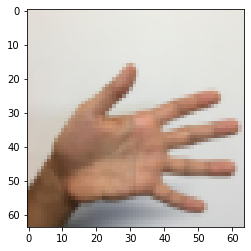

In [50]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Cost after epoch 0 is 1.9136926122009754
Cost after epoch 100 is 1.0490445140749216
Cost after epoch 200 is 0.7560957530513406
Cost after epoch 300 is 0.5909789958968759
Cost after epoch 400 is 0.4832165017724037
Cost after epoch 500 is 0.3931409390643239
Cost after epoch 600 is 0.32362209307029843
Cost after epoch 700 is 0.2616363447159529
Cost after epoch 800 is 0.21027185954153538
Cost after epoch 900 is 0.1716550961136818
Cost after epoch 1000 is 0.15121808787807822
Cost after epoch 1100 is 0.11063402600120753
Cost after epoch 1200 is 0.08940662117674947
Cost after epoch 1300 is 0.061195615271572024
Cost after epoch 1400 is 0.053923174273222685


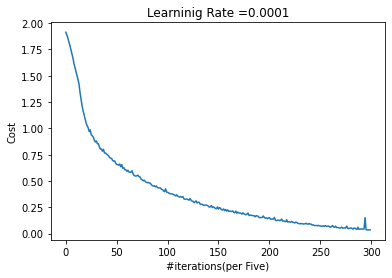

Train Accuracy :  99.90741014480591
Test Accuracy :  72.50000238418579


In [51]:
param = model(X_train,Y_train,X_test,Y_test,layer_dims = [X_train.shape[0],25,12,6,Y_train.shape[0]],optimizer = 'adam',learning_rate = 0.0001,epochs = 1500,minibatch_size = 32,print_cost = True)

Cost after epoch 0 is 0.47926212660968304
Cost after epoch 100 is 0.4469723589718342
Cost after epoch 200 is 0.4242153186351061
Cost after epoch 300 is 0.4072706811130047
Cost after epoch 400 is 0.3932181801646948
Cost after epoch 500 is 0.38122172467410564
Cost after epoch 600 is 0.3700461592525244
Cost after epoch 700 is 0.3594075795263052
Cost after epoch 800 is 0.34879497438669205
Cost after epoch 900 is 0.339221753180027
Cost after epoch 1000 is 0.32967206463217735
Cost after epoch 1100 is 0.3206795044243336
Cost after epoch 1200 is 0.3118211943656206
Cost after epoch 1300 is 0.304268978536129
Cost after epoch 1400 is 0.296419957652688


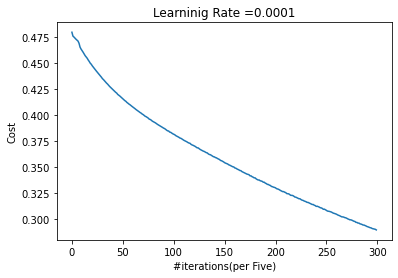

Train Accuracy :  65.18518328666687
Test Accuracy :  64.16666507720947


In [52]:
param = model(X_train,Y_train,X_test,Y_test,layer_dims = [X_train.shape[0],25,12,6,Y_train.shape[0]],optimizer = 'gd',learning_rate = 0.0001,epochs = 1500,minibatch_size = 64,print_cost = True)

Cost after epoch 0 is 0.47484767995774746
Cost after epoch 100 is 0.29589374735951424
Cost after epoch 200 is 0.18757331930100918
Cost after epoch 300 is 0.12285752408206463
Cost after epoch 400 is 0.08422216051258147
Cost after epoch 500 is 0.05859936214983463
Cost after epoch 600 is 0.03770492447074503
Cost after epoch 700 is 0.025599129730835557
Cost after epoch 800 is 0.016889249556697905
Cost after epoch 900 is 0.01119698359980248
Cost after epoch 1000 is 0.007266175030963495
Cost after epoch 1100 is 0.004604469184414484
Cost after epoch 1200 is 0.0029725037020398304
Cost after epoch 1300 is 0.0018225920284749009
Cost after epoch 1400 is 0.0009741782778291963


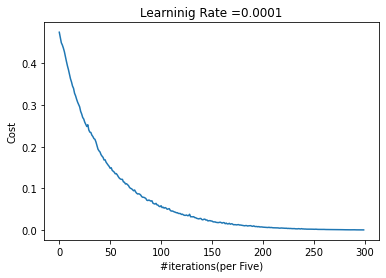

Train Accuracy :  100.0
Test Accuracy :  88.33333253860474


In [53]:
param = model(X_train,Y_train,X_test,Y_test,layer_dims = [X_train.shape[0],25,12,6,Y_train.shape[0]],optimizer = 'adam',learning_rate = 0.0001,epochs = 1500,minibatch_size = 64,print_cost = True)

Cost after epoch 0 is 0.126995662227273
Cost after epoch 100 is 0.12163739837706089
Cost after epoch 200 is 0.11735061276704073
Cost after epoch 300 is 0.11434256471693516
Cost after epoch 400 is 0.11095296032726765
Cost after epoch 500 is 0.10880389530211687
Cost after epoch 600 is 0.10701523069292307
Cost after epoch 700 is 0.10520128160715103
Cost after epoch 800 is 0.10286016203463078
Cost after epoch 900 is 0.10180014092475176
Cost after epoch 1000 is 0.09990091808140278
Cost after epoch 1100 is 0.09799823630601168
Cost after epoch 1200 is 0.09586437977850437
Cost after epoch 1300 is 0.09519731625914574
Cost after epoch 1400 is 0.09380944073200226


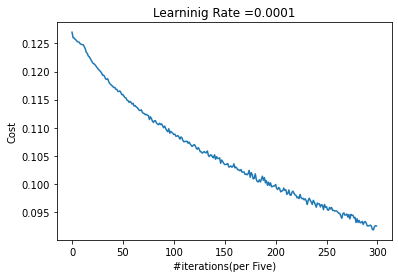

Train Accuracy :  51.75926089286804
Test Accuracy :  50.0


In [54]:
param = model(X_train,Y_train,X_test,Y_test,layer_dims = [X_train.shape[0],25,12,6,Y_train.shape[0]],optimizer = 'gd',learning_rate = 0.0001,epochs = 1500,minibatch_size = 128,print_cost = True)

Cost after epoch 0 is 0.12693217769265175
Cost after epoch 100 is 0.10611116420477629
Cost after epoch 200 is 0.0883286390453577
Cost after epoch 300 is 0.07336250599473715
Cost after epoch 400 is 0.060215136501938105
Cost after epoch 500 is 0.049137207213789225
Cost after epoch 600 is 0.04109332570806146
Cost after epoch 700 is 0.033182807033881545
Cost after epoch 800 is 0.026922398945316672
Cost after epoch 900 is 0.0226977220736444
Cost after epoch 1000 is 0.019781786482781172
Cost after epoch 1100 is 0.015932047041133046
Cost after epoch 1200 is 0.013347978238016367
Cost after epoch 1300 is 0.01076922391075641
Cost after epoch 1400 is 0.0092920251772739


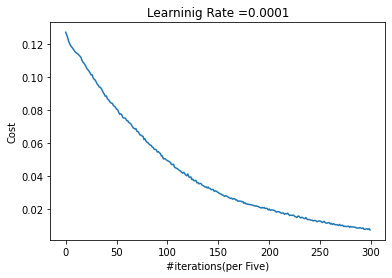

Train Accuracy :  98.42592477798462
Test Accuracy :  80.83333373069763


In [55]:
param = model(X_train,Y_train,X_test,Y_test,layer_dims = [X_train.shape[0],25,12,6,Y_train.shape[0]],optimizer = 'adam',learning_rate = 0.0001,epochs = 1500,minibatch_size = 128,print_cost = True)

In [87]:
print(X_test[:,0].shape,Y_test[:,0].shape)
idx = 15
p = predict(X_test[:,idx].reshape(12288,1),[12288,25,12,6,Y_test.shape[0]],param)
np.set_printoptions(suppress =True)
print('Prediction with probabilities','\n',p)
print('Prediction',np.argmax(p))
print('Actual',Y_test[:,idx].reshape(6,1))

(12288,) (6,)
Prediction with probabilities 
 [[0.  ]
 [0.  ]
 [0.  ]
 [0.8 ]
 [0.01]
 [0.19]]
Prediction 3
Actual [[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]
